In [6]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve
)
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

In [3]:
wget -O data/raw/telco_churn.csv https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

SyntaxError: invalid syntax (3937599368.py, line 1)

In [4]:
df = pd.read_csv("/Users/arnenyecknyeck/Desktop/keystonedata-platform/notebooks/Telco-Customer-Churn.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.tail(10)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
7033,9767-FFLEM,Male,0,No,No,38,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),69.50,2625.25,No
7034,0639-TSIQW,Female,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,Yes
7035,8456-QDAVC,Male,0,No,No,19,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),78.70,1495.1,No
7036,7750-EYXWZ,Female,0,No,No,12,No,No phone service,DSL,No,...,Yes,Yes,Yes,Yes,One year,No,Electronic check,60.65,743.3,No
7037,2569-WGERO,Female,0,No,No,72,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [6]:
df['totalcharges'].isna().sum()

np.int64(0)

In [7]:
# Remove ID column
df = df.drop('customerid', axis=1)

# Fix 'totalcharges' by converting to numeric and replacing bad values with 0
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce').fillna(0.0)


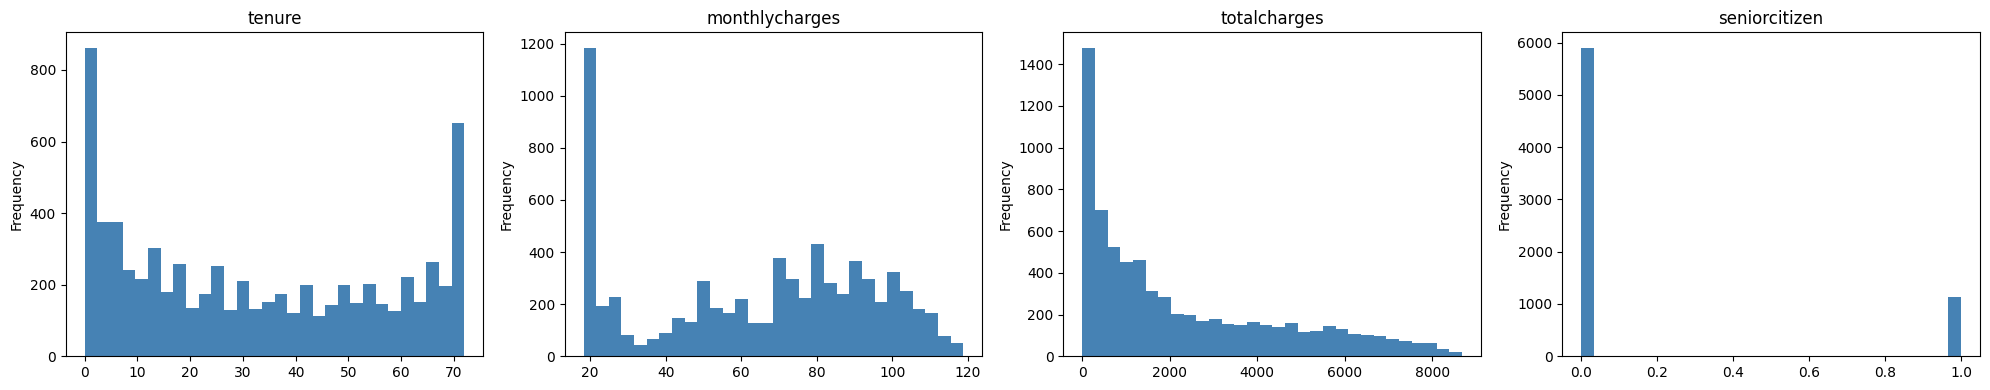

In [8]:
numeric_cols = ['tenure', 'monthlycharges', 'totalcharges', 'seniorcitizen']

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col], bins=30, color='steelblue')
    axes[idx].set_title(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


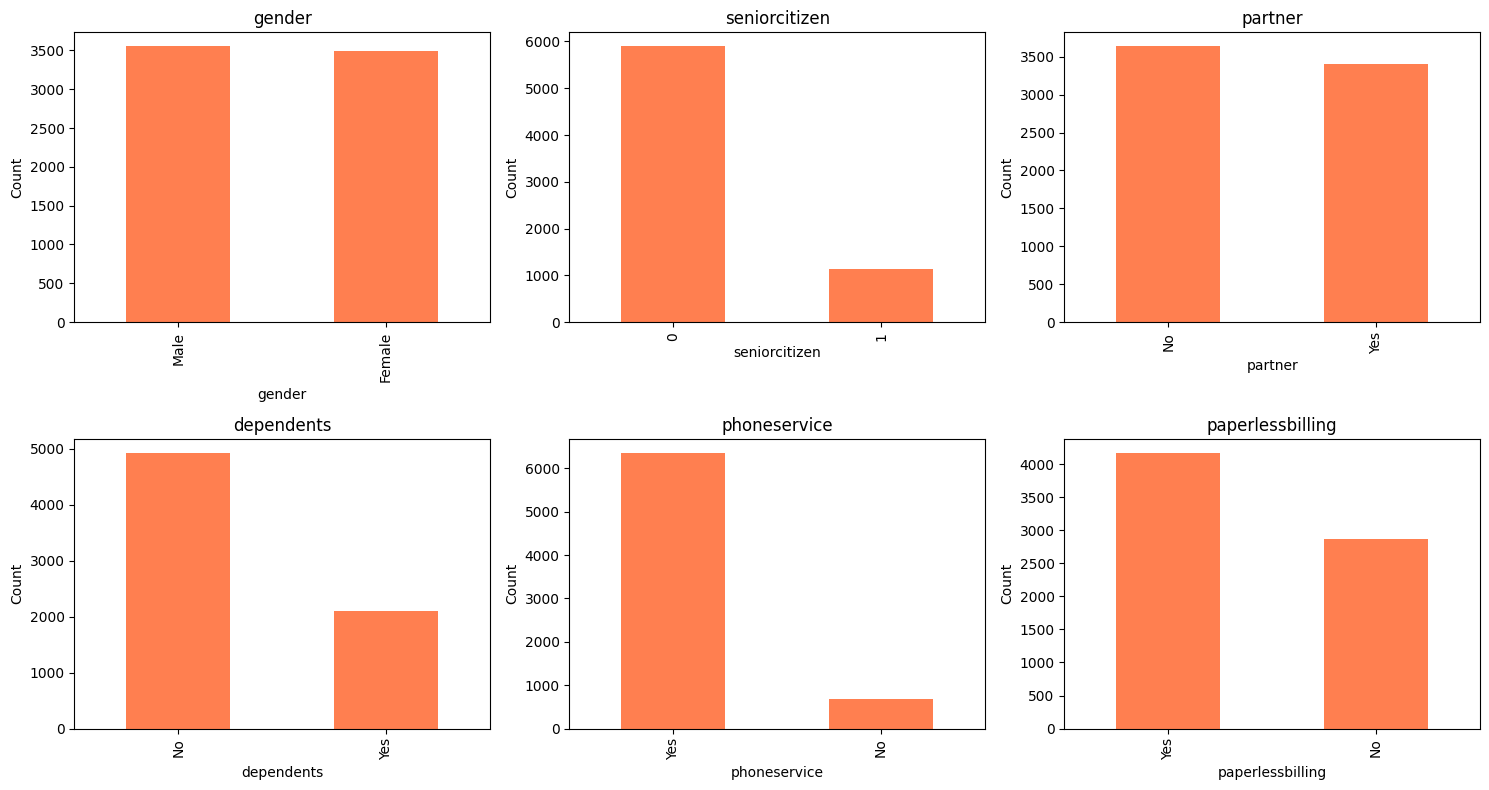

In [9]:
# Categorical columns to visualize
categorical_cols = ['gender', 'seniorcitizen', 'partner', 'dependents',
                    'phoneservice', 'paperlessbilling']

# Create 2x3 grid of bar plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

# Plot value counts for each categorical column
for idx, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[idx], color='coral')
    axes[idx].set_title(col)
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()


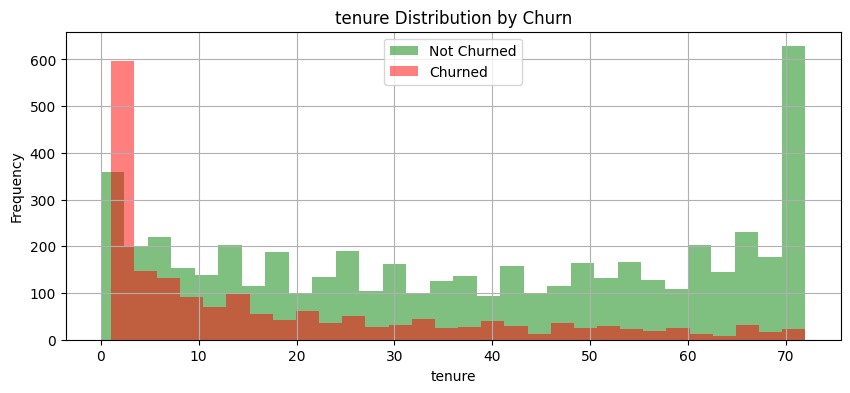

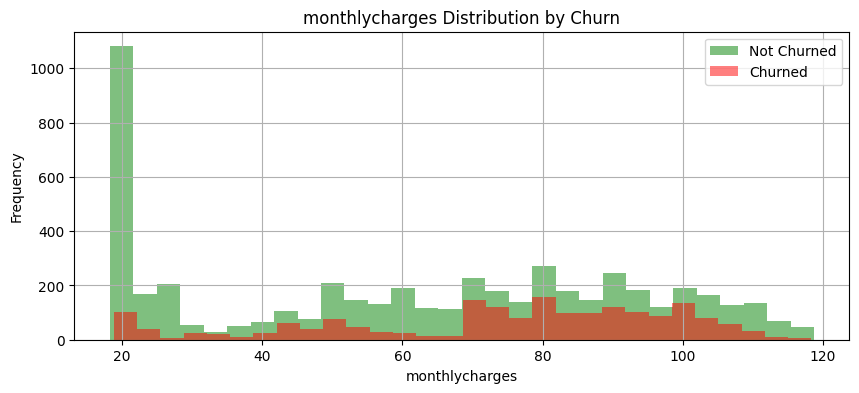

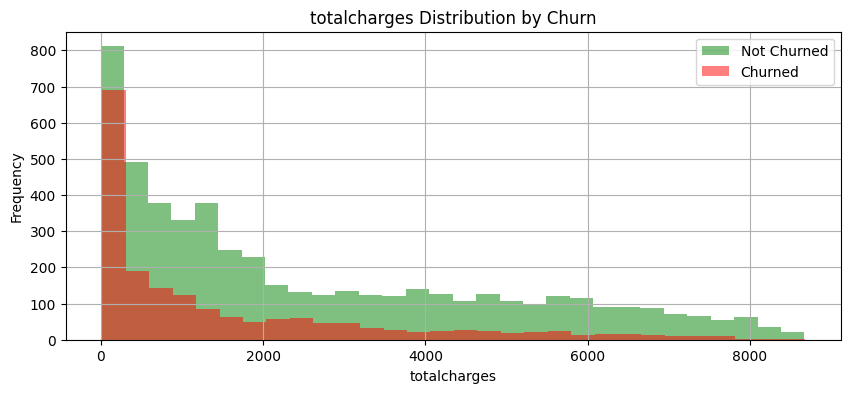

In [10]:
# Distribution of churned vs non-churned customers

for col in ['tenure', 'monthlycharges', 'totalcharges']:
    plt.figure(figsize=(10, 4))
    df[df['churn']=='No'][col].hist(bins=30, alpha=0.5, label='Not Churned', color='green')
    df[df['churn']=='Yes'][col].hist(bins=30, alpha=0.5, label='Churned', color='red')
    plt.title(f'{col} Distribution by Churn')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

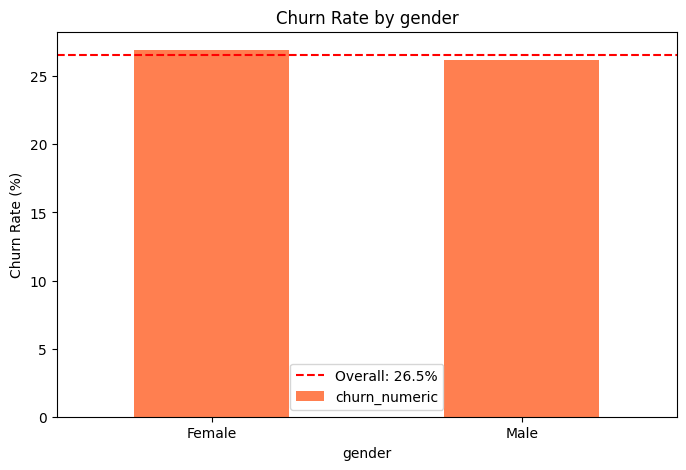

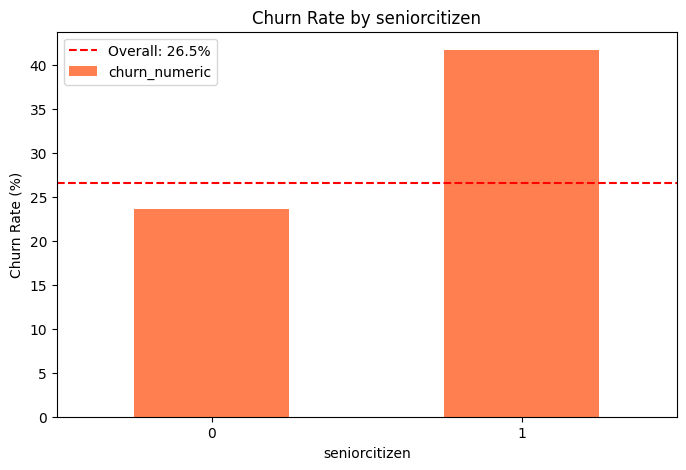

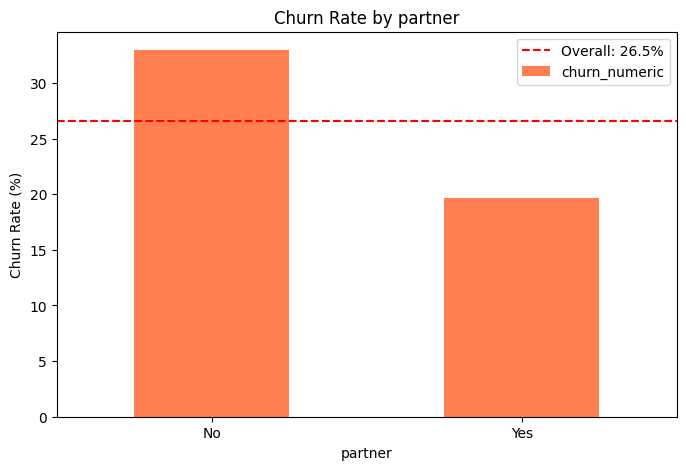

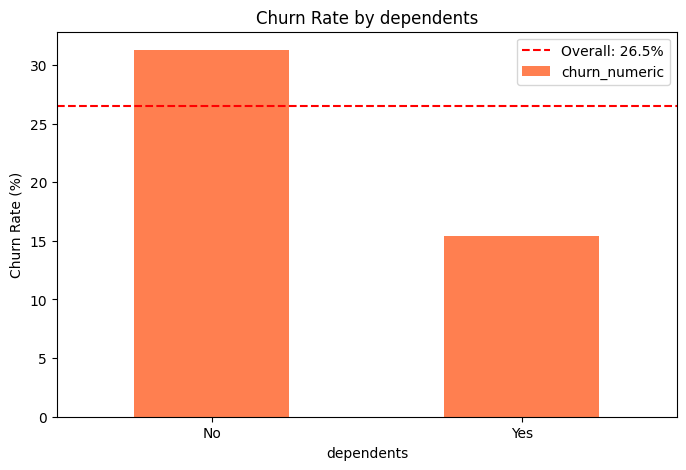

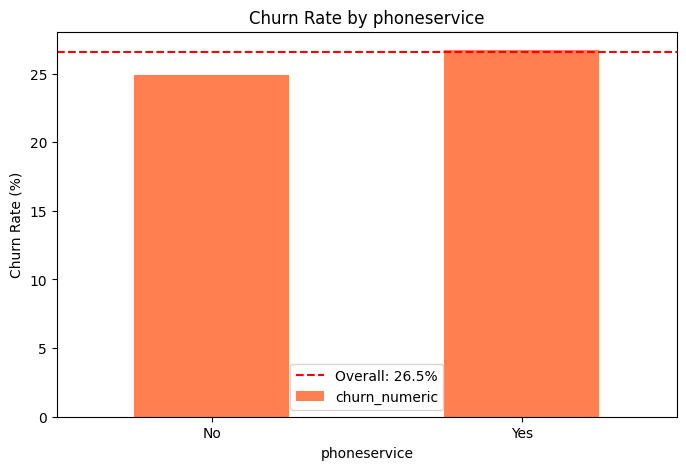

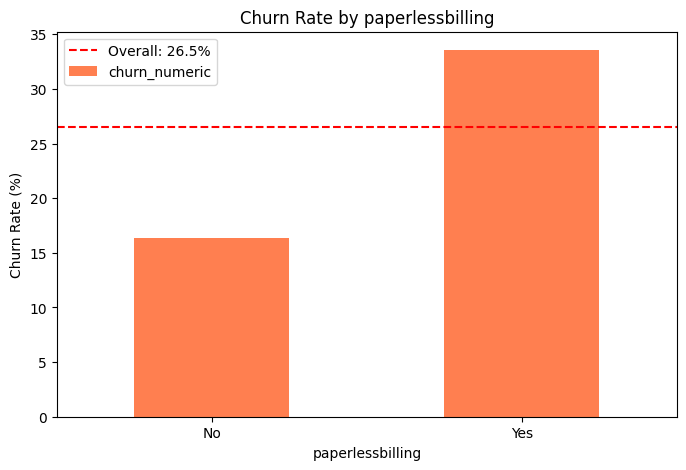

In [11]:
# Churn Rate by Category
categorical_cols = ['gender', 'seniorcitizen', 'partner', 'dependents',
                    'phoneservice', 'paperlessbilling']

# Create numeric churn column once
df['churn_numeric'] = (df['churn'] == 'Yes').astype(int)
overall_churn_rate = df['churn_numeric'].mean() * 100

for col in categorical_cols:
    churn_rate = df.groupby(col)['churn_numeric'].mean() * 100

    plt.figure(figsize=(8, 5))
    churn_rate.plot(kind='bar', color='coral')
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Churn Rate (%)')
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.axhline(y=overall_churn_rate, color='red', linestyle='--',
                label=f'Overall: {overall_churn_rate:.1f}%')
    plt.legend()
    plt.show()

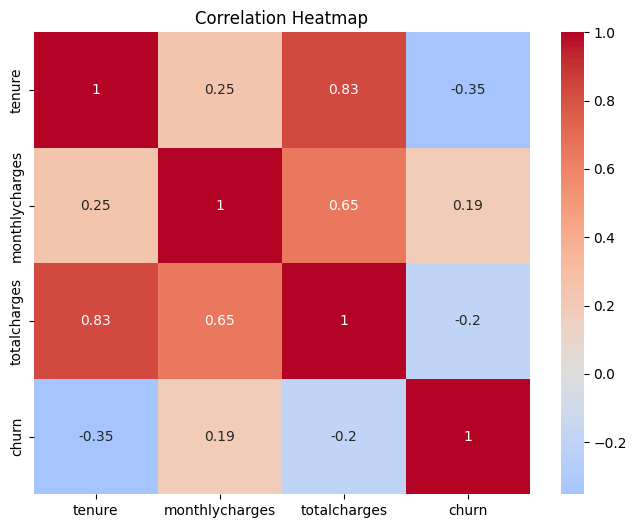

In [12]:

# # Hot encoding label yes:1 no:0
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})

# See relationships between all numerical features
correlation = df[['tenure', 'monthlycharges', 'totalcharges', 'churn']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
print(df.columns.tolist())

['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'churn', 'churn_numeric']


In [14]:
# One-hot encode multi-class categorical columns (drop_first avoids dummy trap)
multiclass_cols = ['multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
                   'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
                   'contract', 'paymentmethod']

df = pd.get_dummies(df, columns=multiclass_cols, drop_first=True)


In [15]:
# BASELINE MODEL

## train test split
X = df.drop('churn', axis = 1).select_dtypes(include=np.number)
y =df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [16]:

dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.73450070989115

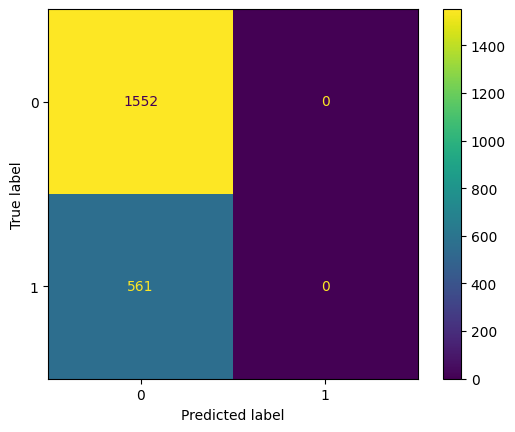

In [17]:
ConfusionMatrixDisplay.from_estimator(dummy_clf, X_test, y_test);

In [18]:
## FEATURE PREP WITH ENCODING

# # binary hot encoding
binary_cols = ['gender', 'partner', 'dependents', 'phoneservice', 'paperlessbilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})




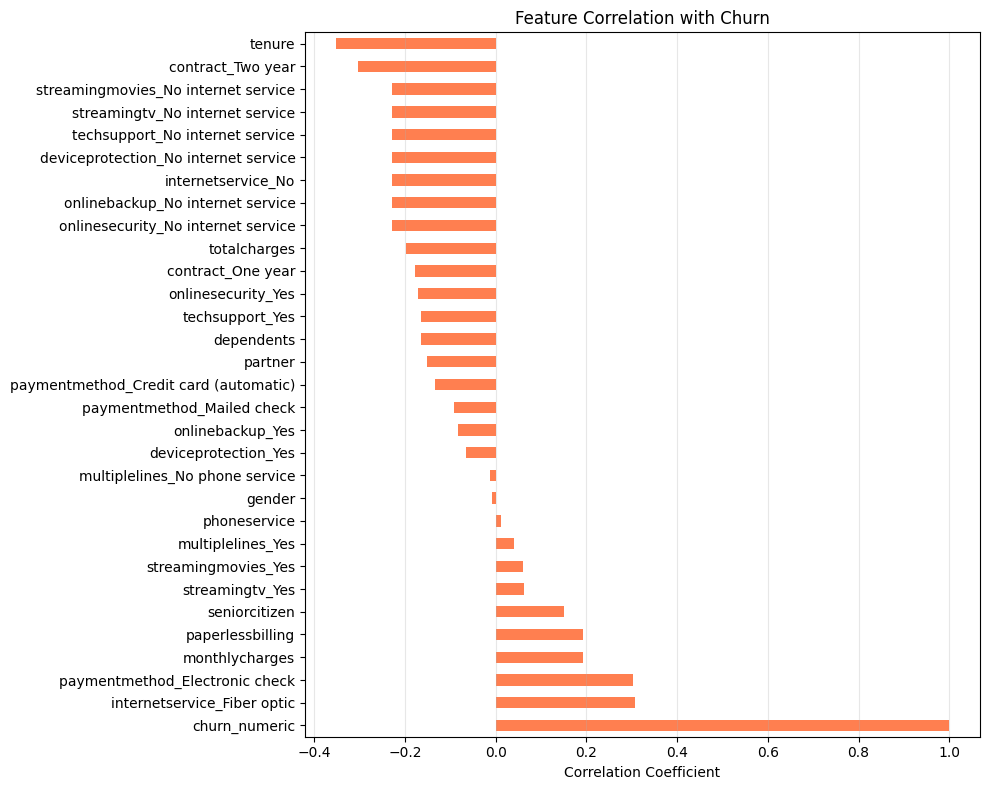

In [19]:
## Feature corr with Churm
churn_corr = df.corr()['churn'].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
churn_corr[1:].plot(kind='barh', color='coral')
plt.title('Feature Correlation with Churn')
plt.xlabel('Correlation Coefficient')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

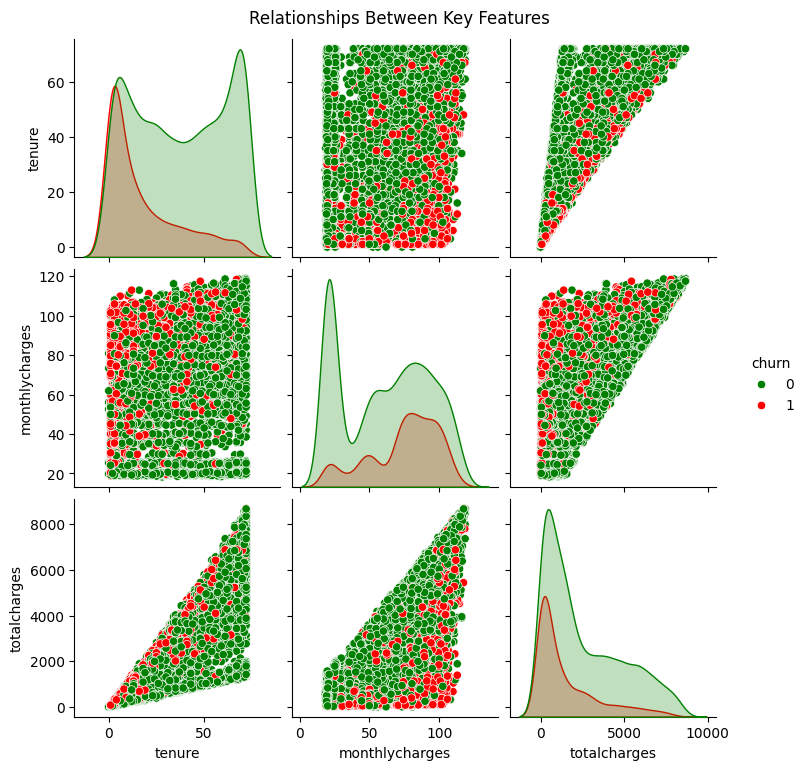

In [20]:
## pairplot key features
key_features = ['tenure', 'monthlycharges', 'totalcharges', 'churn']
sns.pairplot(df[key_features], hue='churn', palette={0: 'green', 1: 'red'})
plt.suptitle('Relationships Between Key Features', y=1.02)
plt.show()

In [21]:
## check for independancy
corr = X.corr(method = 'pearson', numeric_only= True)
corr_pairs = corr.unstack().drop_duplicates().abs().sort_values(ascending = False)
corr_pairs = corr_pairs[corr_pairs < 1]
corr_pairs.head(10)

tenure          totalcharges      0.826178
monthlycharges  totalcharges      0.651174
tenure          churn_numeric     0.352229
                monthlycharges    0.247900
seniorcitizen   monthlycharges    0.220173
totalcharges    churn_numeric     0.198324
monthlycharges  churn_numeric     0.193356
seniorcitizen   churn_numeric     0.150889
                totalcharges      0.103006
                tenure            0.016567
dtype: float64

In [22]:
## check if dependent variable is binary.
y.value_counts()

#it is binary


churn
0    5174
1    1869
Name: count, dtype: int64

/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/u

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

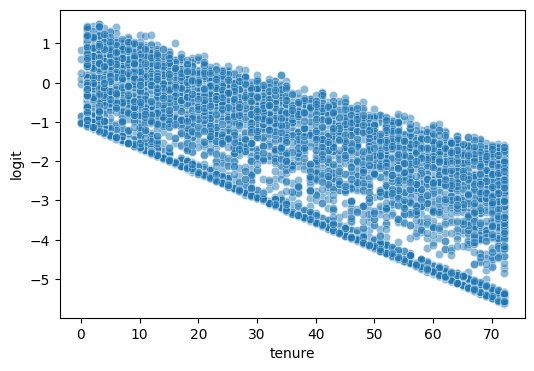

In [23]:
## Check for linearity
# Define continuous numeric predictors (excluding ID and const)
cont_feats = ['tenure', 'monthlycharges', 'totalcharges']

# Create a figure
y = df['churn']

model = LogisticRegression(max_iter=1000)
model.fit(df[cont_feats], y)

df['pred_prob'] = model.predict_proba(df[cont_feats])[:, 1]

df['logit'] = np.log(df['pred_prob'] / (1 - df['pred_prob']))


for feature in cont_feats:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df['logit'], alpha=0.5)
    sns.regplot(x=df[feature], y=df['logit'], scatter=False, color='red', lowess=True)
    plt.title(f'Linearity Check: {feature} vs Logit')
    plt.xlabel(feature)
    plt.ylabel('Logit (log-odds)')
    plt.show()


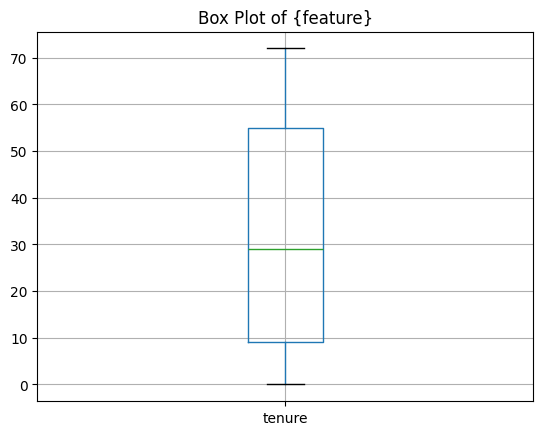

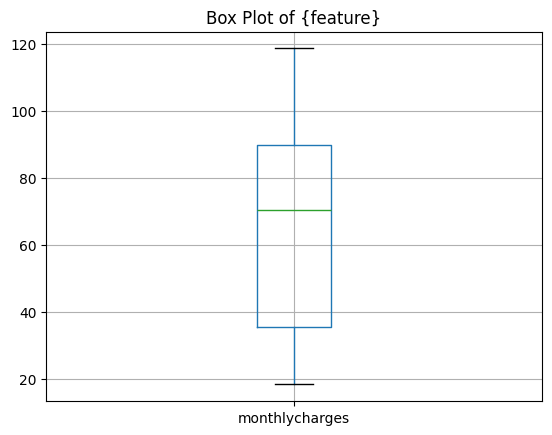

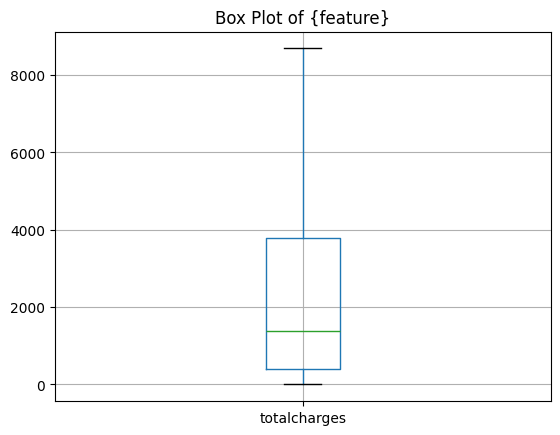

In [24]:
# Checking for outliers.
cont_feats = ['tenure', 'monthlycharges', 'totalcharges']
for feature in cont_feats:
  df.boxplot(column=feature)
  plt.title("Box Plot of {feature}")
  plt.show()

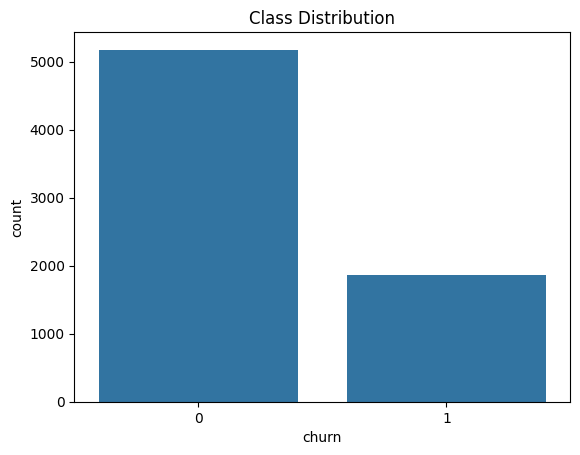

In [25]:
## check for class imbalance
sns.countplot(x=df['churn'])
plt.title("Class Distribution")
plt.show()

In [26]:
## log transformation to continuous features due to non linearity. Log transform (use log1p to handle zeros)
df['log_tenure'] = np.log1p(df['tenure'])
df['log_monthlycharges'] = np.log1p(df['monthlycharges'])
df['log_totalcharges'] = np.log1p(df['totalcharges'])

# Update continuous features list
cont_feats = ['log_tenure', 'log_monthlycharges', 'log_totalcharges']



In [27]:
# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check if any feature is identical to target
for col in X.columns:
    if (X[col] == y).all():
        print(f" {col} is identical to target!")

Duplicate rows: 22
 churn_numeric is identical to target!


In [28]:
# Remove duplicate rows
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")

After removing duplicates: (7021, 37)


# ------------------ LOGISTIC REGRESSION MODEL ------------------ #



Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.87      0.74      0.80      1550
     Churned       0.49      0.69      0.57       557

    accuracy                           0.73      2107
   macro avg       0.68      0.71      0.68      2107
weighted avg       0.77      0.73      0.74      2107



/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/arnenyecknyeck/Libr

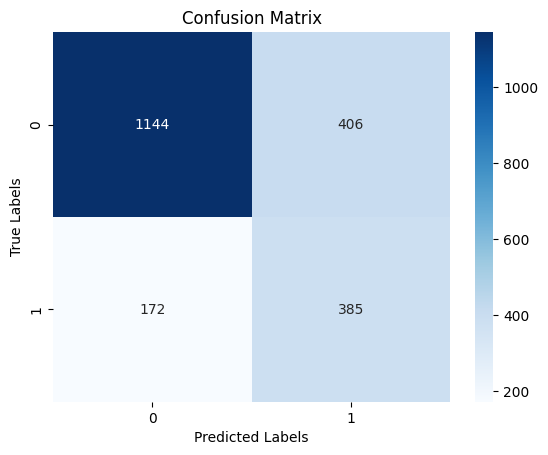

In [29]:

# Drop BOTH churn columns from features
lrX = df.drop(['churn', 'churn_numeric'], axis=1).select_dtypes(include=np.number)
lry = df['churn']

lrX_train, lrX_test, lry_train, lry_test = train_test_split(
    lrX, lry, test_size=0.3, random_state=42, stratify=lry
)

# Apply SMOTE
smote = SMOTE(random_state=42)
lrX_resampled, lry_resampled = smote.fit_resample(lrX_train, lry_train)

# Train model
model = LogisticRegression(max_iter=10000, solver='liblinear')
model.fit(lrX_resampled, lry_resampled)

# Predictions
lry_pred = model.predict(lrX_test)
lry_pred_proba = model.predict_proba(lrX_test)[:, 1]

# Metrics
accuracy = accuracy_score(lry_test, lry_pred)
f1 = f1_score(lry_test, lry_pred)
roc_auc = roc_auc_score(lry_test, lry_pred_proba)

print("\nClassification Report:")
print(classification_report(lry_test, lry_pred, target_names=['Not Churned', 'Churned']))

# Calculate the confusion matrix
cm = confusion_matrix(lry_test, lry_pred)


# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ------------------ RANDOM FOREST MODEL ------------------ #


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1556
           1       0.60      0.46      0.52       551

    accuracy                           0.78      2107
   macro avg       0.71      0.68      0.69      2107
weighted avg       0.77      0.78      0.77      2107



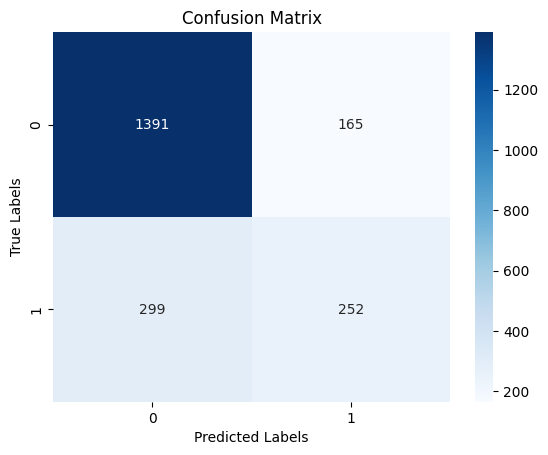

In [30]:
# Features and target
rfX = df.drop(['churn', 'churn_numeric'], axis=1).select_dtypes(include=np.number)
rfy = df['churn']

# Train-test split
rfX_train, rfX_test, rfy_train, rfy_test = train_test_split(
    rfX, rfy, test_size=0.3, random_state=42
)

# Train RF model
forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

forest.fit(rfX_train, rfy_train)

# Predictions
rfy_pred = forest.predict(rfX_test)
rfy_pred_proba = forest.predict_proba(rfX_test)[:, 1]   # <-- FIXED NAME

print("\nClassification Report:")
print(classification_report(rfy_test, rfy_pred))

# Confusion Matrix
cm = confusion_matrix(rfy_test, rfy_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## CHECKING SVM ASSUMPTIONS.

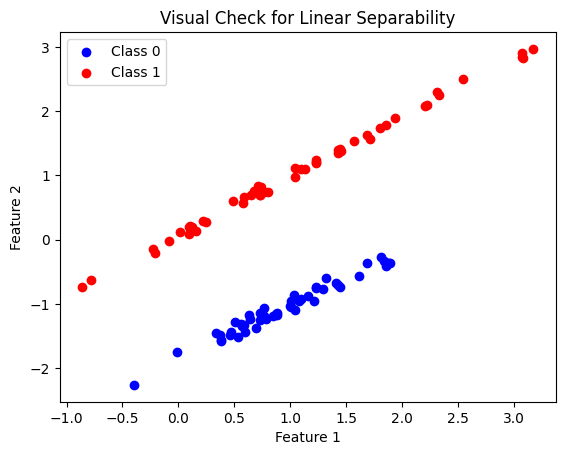

In [31]:
#  Check for Linear Separability

# Create sample data
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0,
                          n_informative=2, n_clusters_per_class=1, random_state=42)

# Plot
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], c='blue', label='Class 0')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], c='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Visual Check for Linear Separability')
plt.show()

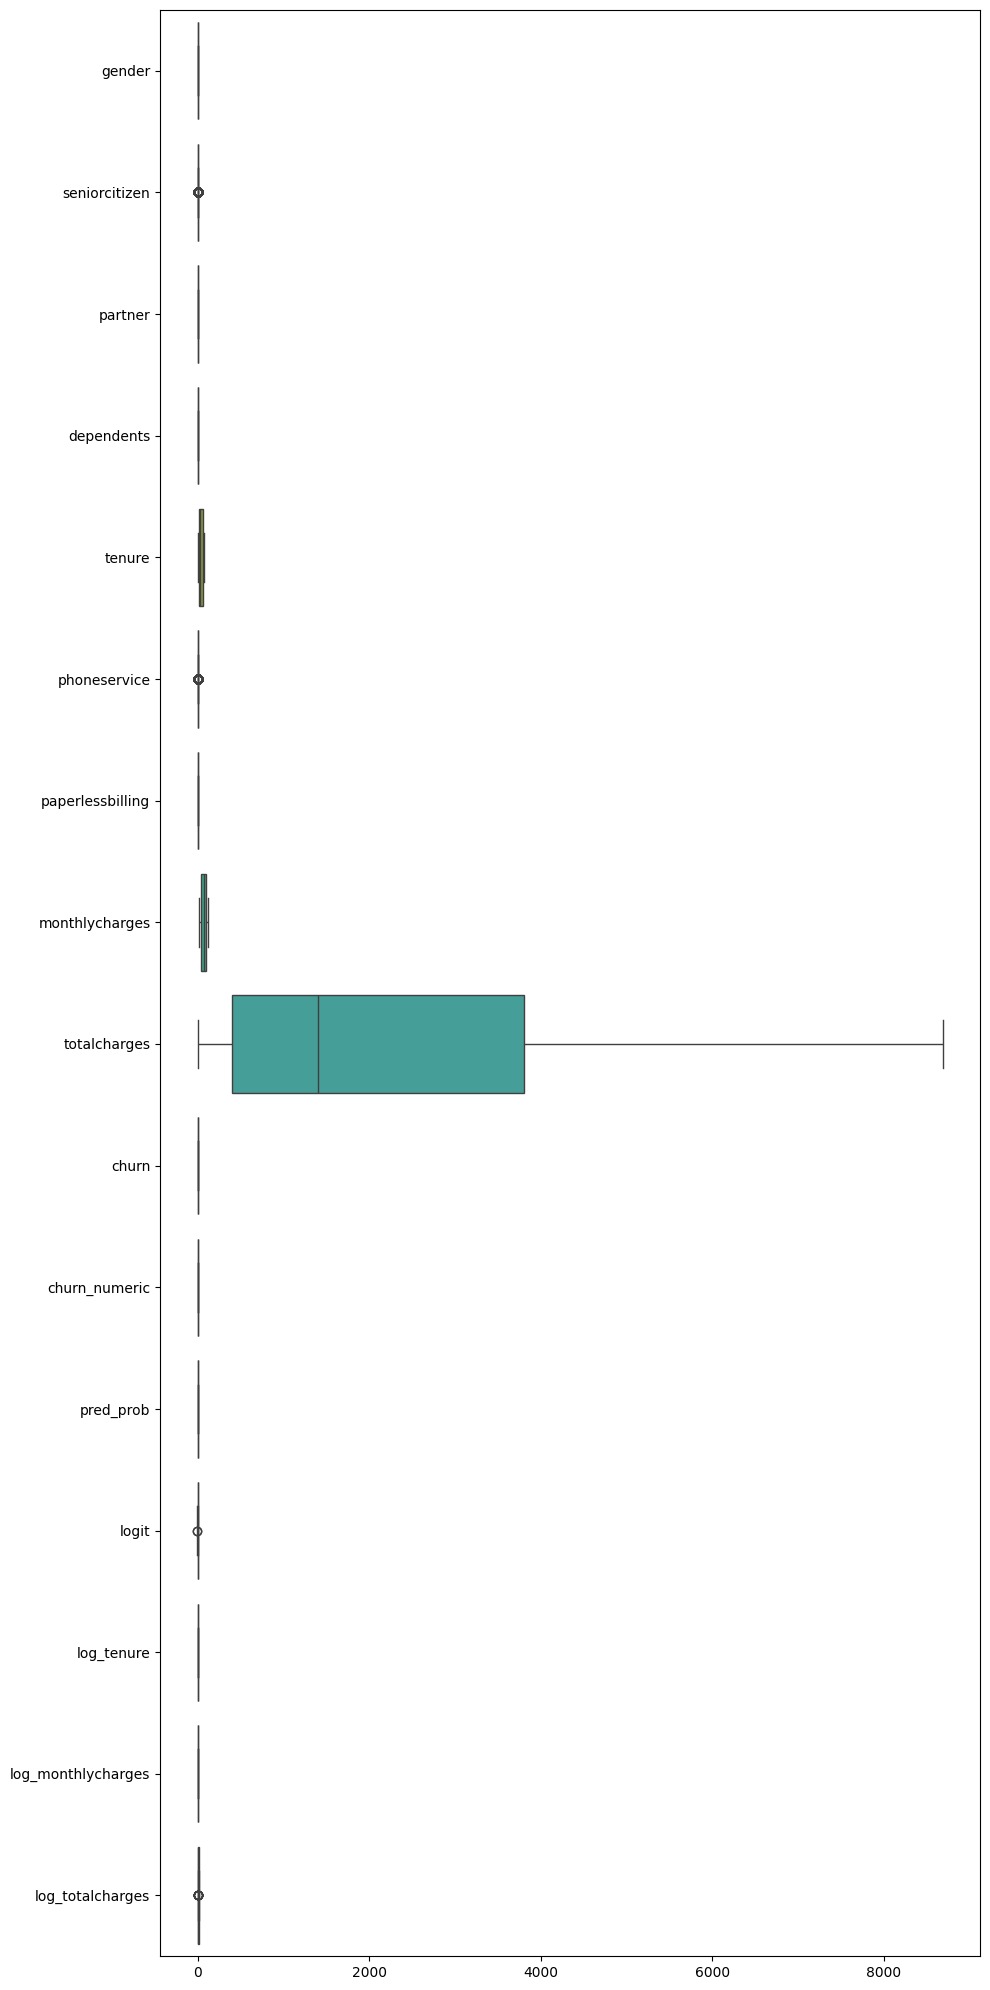

In [32]:
## Checking for outliers
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 20))
sns.boxplot(data=numeric_df, orient='h')
plt.tight_layout()
plt.show()




Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.81      0.92      0.87      1556
     Churned       0.65      0.41      0.50       551

    accuracy                           0.79      2107
   macro avg       0.73      0.67      0.68      2107
weighted avg       0.77      0.79      0.77      2107



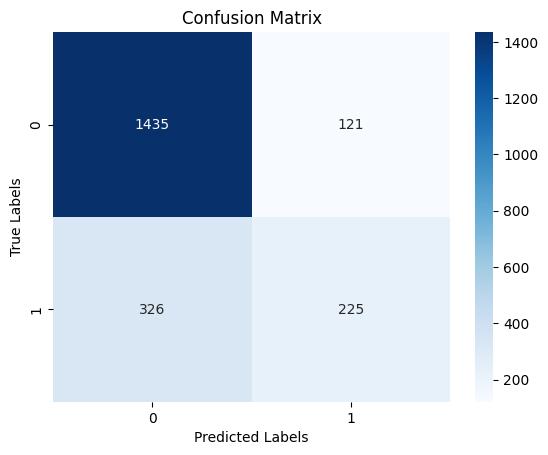

In [33]:
svmX = df.drop(['churn', 'churn_numeric'], axis=1).select_dtypes(include=np.number)
svmy = df['churn']

svmX_train, svmX_test, svmy_train, svmy_test = train_test_split(svmX, svmy, test_size=0.3, random_state=42)

#feature scalling
scaler = StandardScaler()
svmX_train_scaled = scaler.fit_transform(svmX_train)
svmX_test_scaled  = scaler.transform(svmX_test)

# SVM model
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True)
# Fit the model
svm_model.fit(svmX_train_scaled, svmy_train)

#Predict
svmy_pred = svm_model.predict(svmX_test_scaled)


print("\nClassification Report:")
print(classification_report(svmy_test, svmy_pred, target_names=['Not Churned', 'Churned']))

#Calculate the confusion matrix
cm = confusion_matrix(svmy_test, svmy_pred)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Before SMOTE: {0: 3614, 1: 1300}
After SMOTE: {0: 3614, 1: 3614}


/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.89      0.71      0.79      1550
     Churned       0.49      0.77      0.59       557

    accuracy                           0.72      2107
   macro avg       0.69      0.74      0.69      2107
weighted avg       0.79      0.72      0.74      2107



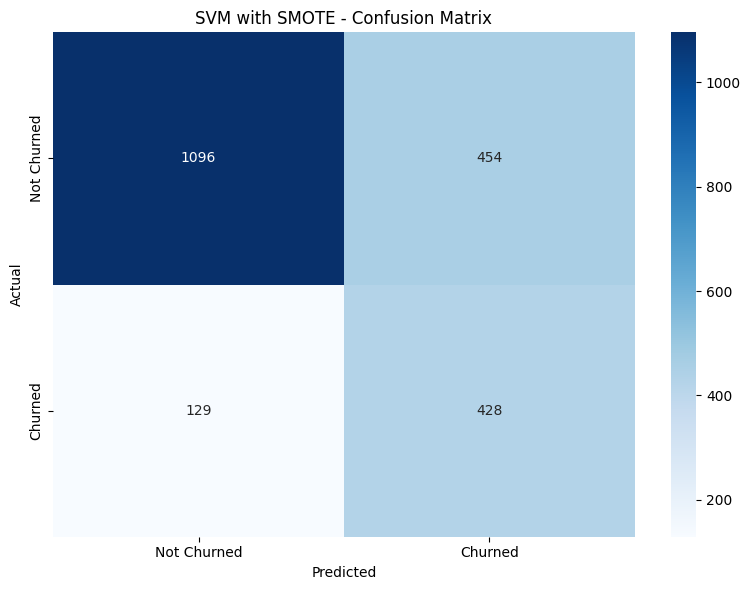

In [34]:
## IMPLIMENTING SMOTE FUNCTION TO IMPROVE RECALL. SVM WITH SMOTE

# Remove duplicates
df = df.drop_duplicates()

svmX = df.drop(['churn', 'churn_numeric'], axis=1).select_dtypes(include=np.number)
svmy = df['churn']

# Train-test split with stratify
svmX_train, svmX_test, svmy_train, svmy_test = train_test_split(
    svmX, svmy, test_size=0.3, random_state=42, stratify=svmy
)

# Feature scaling
scaler = StandardScaler()
svmX_train_scaled = scaler.fit_transform(svmX_train)
svmX_test_scaled = scaler.transform(svmX_test)

# SMOTE
smote = SMOTE(random_state=42)
svmX_train_resampled, svmy_train_resampled = smote.fit_resample(svmX_train_scaled, svmy_train)

print(f"Before SMOTE: {svmy_train.value_counts().to_dict()}")
print(f"After SMOTE: {pd.Series(svmy_train_resampled).value_counts().to_dict()}")

# SVM model
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)

# Fit the model on resampled data
svm_model.fit(svmX_train_resampled, svmy_train_resampled)

# Predict
svmy_pred = svm_model.predict(svmX_test_scaled)
svmy_pred_proba = svm_model.predict_proba(svmX_test_scaled)[:, 1]


print("\nClassification Report:")
print(classification_report(svmy_test, svmy_pred, target_names=['Not Churned', 'Churned']))

# # Confusion Matrix
cm = confusion_matrix(svmy_test, svmy_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM with SMOTE - Confusion Matrix')
plt.tight_layout()
plt.show()

In [35]:
# ------------------ SVM WITH SMOTE + THRESHOLD TUNING ------------------ #

svmX = df.drop(['churn', 'churn_numeric'], axis=1).select_dtypes(include=np.number)
svmy = df['churn']

# Train-test split
svmX_train, svmX_test, svmy_train, svmy_test = train_test_split(
    svmX, svmy, test_size=0.3, random_state=42, stratify=svmy
)

# Scaling
scaler = StandardScaler()
svmX_train_scaled = scaler.fit_transform(svmX_train)
svmX_test_scaled = scaler.transform(svmX_test)

# Apply SMOTE
smote = SMOTE(sampling_strategy=0.75, random_state=42)
svmX_train_resampled, svmy_train_resampled = smote.fit_resample(
    svmX_train_scaled, svmy_train
)

# Train SVM model
svm_model = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    probability=True,
    random_state=42
)
svm_model.fit(svmX_train_resampled, svmy_train_resampled)

# Predict probabilities
svmy_pred_proba = svm_model.predict_proba(svmX_test_scaled)[:, 1]

# Threshold tuning
thresholds = [0.45, 0.50, 0.55, 0.60, 0.65]
results = []

for threshold in thresholds:
    y_pred_thresh = (svmy_pred_proba >= threshold).astype(int)
    prec = precision_score(svmy_test, y_pred_thresh)
    rec = recall_score(svmy_test, y_pred_thresh)
    f1 = f1_score(svmy_test, y_pred_thresh)
    results.append({'Threshold': threshold, 'Precision': prec, 'Recall': rec, 'F1': f1})
    print(f"Threshold {threshold:.2f}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

results_df = pd.DataFrame(results)

# Determine optimal threshold
best_idx = results_df['F1'].idxmax()
optimal_threshold = results_df.loc[best_idx, 'Threshold']
print(f"\nBest threshold: {optimal_threshold}")

# Final prediction using optimal threshold
svmy_pred_optimal = (svmy_pred_proba >= optimal_threshold).astype(int)

# Classification Report
print("\nClassification Report:")
print(classification_report(svmy_test, svmy_pred_optimal, target_names=['Not Churned', 'Churned']))

# Default threshold comparison
default_pred = (svmy_pred_proba >= 0.5).astype(int)
default_precision = precision_score(svmy_test, default_pred)
default_recall = recall_score(svmy_test, default_pred)


/Users/arnenyecknyeck/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Threshold 0.45: Precision=0.514, Recall=0.682, F1=0.586
Threshold 0.50: Precision=0.525, Recall=0.655, F1=0.583
Threshold 0.55: Precision=0.543, Recall=0.634, F1=0.585
Threshold 0.60: Precision=0.563, Recall=0.610, F1=0.586
Threshold 0.65: Precision=0.588, Recall=0.571, F1=0.579

Best threshold: 0.45

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.87      0.77      0.82      1550
     Churned       0.51      0.68      0.59       557

    accuracy                           0.75      2107
   macro avg       0.69      0.73      0.70      2107
weighted avg       0.78      0.75      0.76      2107



# ------------------ XGBOOST IMPLEMENTATION ------------------ #

[0]	train-logloss:0.66510	test-logloss:0.66579


[10]	train-logloss:0.54465	test-logloss:0.54855
[20]	train-logloss:0.51415	test-logloss:0.52058
[30]	train-logloss:0.50175	test-logloss:0.51297
[40]	train-logloss:0.49410	test-logloss:0.50880
[49]	train-logloss:0.48941	test-logloss:0.50655

XGBOOST RESULTS
Accuracy:  0.7337
Precision: 0.4977
Recall:    0.7828
F1-Score:  0.6085
ROC-AUC:   0.8291

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.90      0.72      0.80      1550
     Churned       0.50      0.78      0.61       557

    accuracy                           0.73      2107
   macro avg       0.70      0.75      0.70      2107
weighted avg       0.79      0.73      0.75      2107



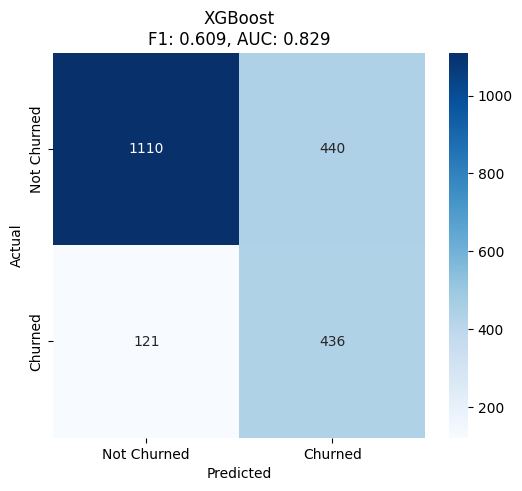

In [36]:
import numpy as np

# Features and target
xgbX = df.drop(['churn', 'churn_numeric'], axis=1).select_dtypes(include=np.number)
xgby = df['churn']

# Train-test split (stratified)
xgbX_train, xgbX_test, xgby_train, xgby_test = train_test_split(
    xgbX, xgby,
    test_size=0.3,
    random_state=42,
    stratify=xgby
)

# Convert to DMatrix (REMOVED enable_categorical)
xgb_train = xgb.DMatrix(xgbX_train, label=xgby_train)
xgb_test  = xgb.DMatrix(xgbX_test,  label=xgby_test)

# Class imbalance handling
scale_pos = len(xgby_train[xgby_train == 0]) / len(xgby_train[xgby_train == 1])

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos
}

# Train model with early stopping
evals = [(xgb_train, "train"), (xgb_test, "test")]

model = xgb.train(
    params=params,
    dtrain=xgb_train,
    num_boost_round=50,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=10
)

# Predictions
xgby_pred_proba = model.predict(xgb_test)
xgby_pred = (xgby_pred_proba > 0.5).astype(int)

# Performance metrics
accuracy = accuracy_score(xgby_test, xgby_pred)
precision = precision_score(xgby_test, xgby_pred)
recall = recall_score(xgby_test, xgby_pred)
f1 = f1_score(xgby_test, xgby_pred)
roc_auc = roc_auc_score(xgby_test, xgby_pred_proba)

print("\n" + "="*60)
print("XGBOOST RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(xgby_test, xgby_pred, target_names=['Not Churned', 'Churned']))

# Confusion Matrix
cm = confusion_matrix(xgby_test, xgby_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title(f"XGBoost\nF1: {f1:.3f}, AUC: {roc_auc:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

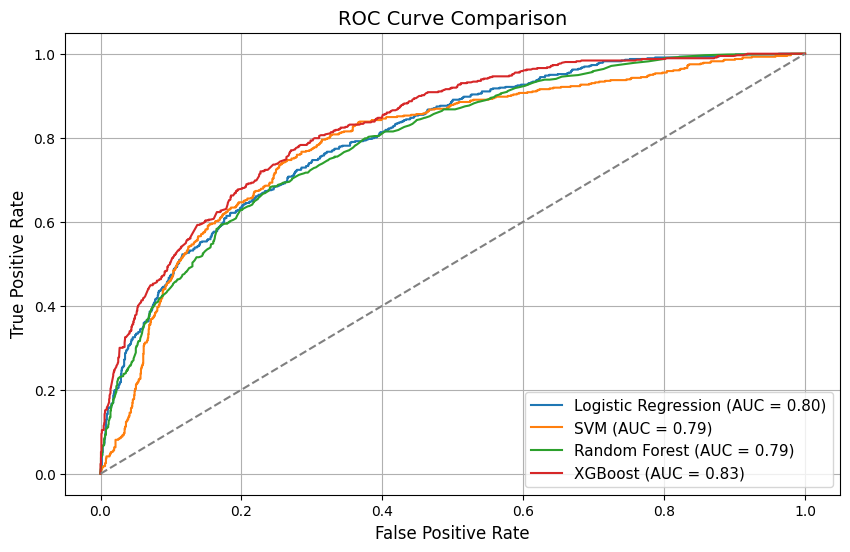

In [37]:

# ------------------ COMPUTE ROC VALUES ------------------ #
# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(lry_test, lry_pred_proba)

# # SVM
fpr_svm, tpr_svm, _ = roc_curve(svmy_test, svmy_pred_proba)

# # Random Forest
fpr_rf, tpr_rf, _ = roc_curve(rfy_test, rfy_pred_proba)

# # XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(xgby_test, xgby_pred_proba)

# # ------------------ PLOT ROC CURVE ------------------ #
plt.figure(figsize=(10, 6))

plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(lry_test, lry_pred_proba):.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_score(svmy_test, svmy_pred_proba):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(rfy_test, rfy_pred_proba):.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(xgby_test, xgby_pred_proba):.2f})")

# # Baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.title("ROC Curve Comparison", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True)
plt.show()


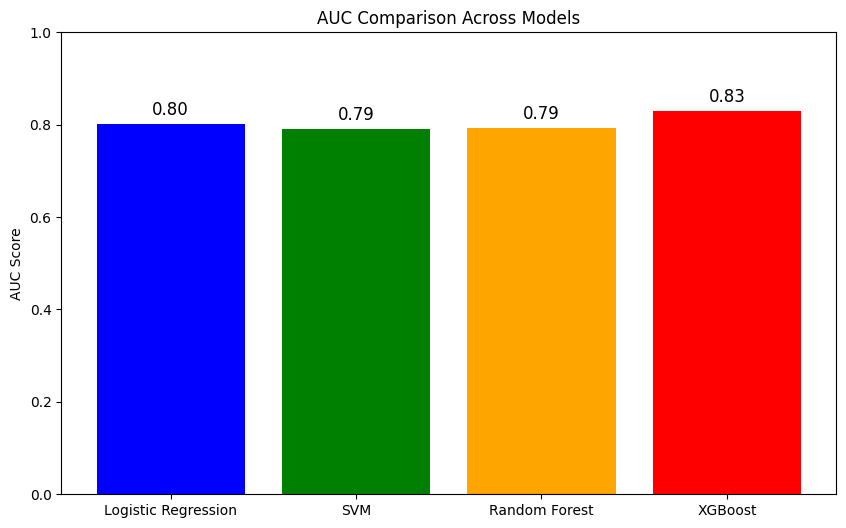

In [38]:
# ------------------ COMPUTE AUC VALUES ------------------ #
auc_lr  = roc_auc_score(lry_test,  lry_pred_proba)
auc_svm = roc_auc_score(svmy_test, svmy_pred_proba)
auc_rf  = roc_auc_score(rfy_test,  rfy_pred_proba)
auc_xgb = roc_auc_score(xgby_test, xgby_pred_proba)

model_names = ["Logistic Regression", "SVM", "Random Forest", "XGBoost"]
auc_scores  = [auc_lr, auc_svm, auc_rf, auc_xgb]

# ------------------ PLOT HISTOGRAM / BAR CHART ------------------ #
plt.figure(figsize=(10, 6))
plt.bar(model_names, auc_scores, color=['blue','green','orange','red'])
plt.ylabel("AUC Score")
plt.title("AUC Comparison Across Models")
plt.ylim(0, 1)

# Label each bar
for i, v in enumerate(auc_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)

plt.show()


In [39]:
cv_results = xgb.cv(
    params=params,
    dtrain=xgb.DMatrix(xgbX, label=xgby),
    num_boost_round=200,
    nfold=5,
    stratified=True,
    metrics="auc",
    early_stopping_rounds=10,
    seed=42
)
print(cv_results)
cv_results.tail()

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.809736       0.002444       0.800214      0.011063
1         0.816388       0.003751       0.806586      0.010561
2         0.820748       0.002740       0.811171      0.011439
3         0.822019       0.002656       0.813060      0.010784
4         0.823876       0.002363       0.814505      0.010095
..             ...            ...            ...           ...
75        0.849590       0.001698       0.829038      0.007093
76        0.849815       0.001699       0.829110      0.007056
77        0.850035       0.001840       0.829139      0.007086
78        0.850246       0.001683       0.829123      0.007099
79        0.850472       0.001688       0.829208      0.007173

[80 rows x 4 columns]


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
75,0.849590,0.001698,0.829038,0.007093
76,0.849815,0.001699,0.829110,0.007056
77,0.850035,0.001840,0.829139,0.007086
78,0.850246,0.001683,0.829123,0.007099
79,0.850472,0.001688,0.829208,0.007173


In [40]:
best_auc = cv_results["test-auc-mean"].max()
best_auc


np.float64(0.8292078426648507)

In [41]:
best_round = cv_results["test-auc-mean"].idxmax()
best_round


79

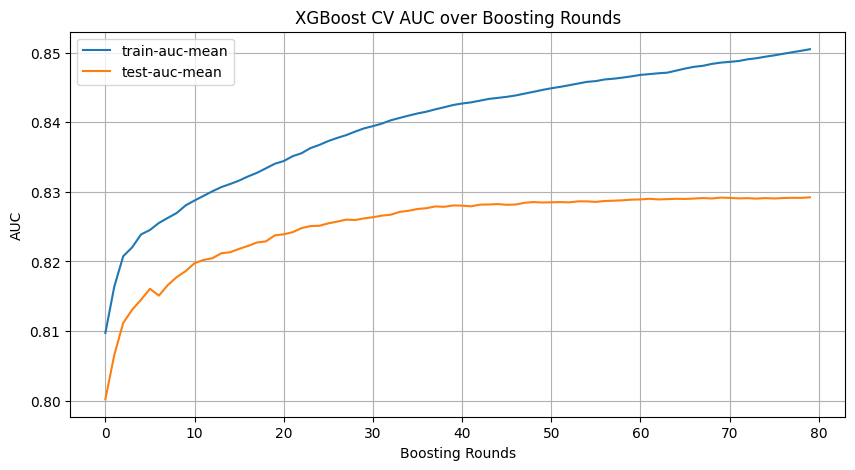

In [42]:
cv_results[["train-auc-mean", "test-auc-mean"]].plot(figsize=(10,5))
plt.title("XGBoost CV AUC over Boosting Rounds")
plt.xlabel("Boosting Rounds")
plt.ylabel("AUC")
plt.grid(True)
plt.show()



In [43]:

## now that we have trained the model, we can look at the features that are important.
importance = model.get_score()
importance = model.get_score(importance_type='gain')
pd.DataFrame({
    "feature": importance.keys(),
    "importance": importance.values()
}).sort_values("importance", ascending=False)


,feature,importance
9,pred_prob,136.534988
6,paperlessbilling,34.073746
1,seniorcitizen,19.608627
3,dependents,16.830149
5,phoneservice,15.569779
7,monthlycharges,14.649055
4,tenure,13.860016
8,totalcharges,11.184643
2,partner,4.677481
0,gender,3.347232


<Figure size 1000x800 with 0 Axes>

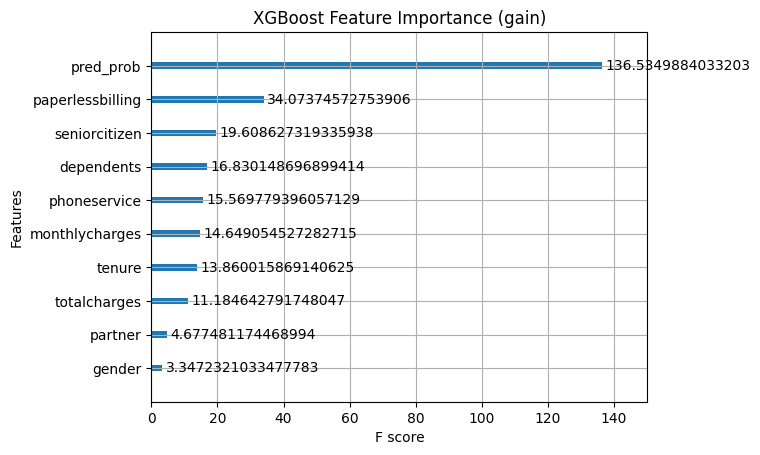

In [44]:
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='gain') 
plt.title("XGBoost Feature Importance (gain)")
plt.show()

In [45]:
## saving the best model
model.save_model("best_xgb_model.json")
